In [1]:
import sys
sys.path.append("/home/amigos/seigyo/analy/shiotani/git/analy_n2data/")
import necstdb
import math
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import n2analy
import xarray as xr
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit

In [2]:
path = '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter'

In [3]:
data = n2analy.get_data(path,'03')

  0%|          | 0/3 [00:00<?, ?it/s]

read end
31.0 OFF 0.0 0.0


100%|██████████| 3/3 [00:00<00:00, 21.92it/s]


31.0 ON 0.0 0.0


In [5]:
xFFTS_Data_topics = [
    
    'xffts_board01',
    'xffts_board02',
    'xffts_board03',
    'xffts_board04',
    'xffts_board05',
    'xffts_board06',
    'xffts_board07',
    'xffts_board08',
    'xffts_board09',
    'xffts_board10',
    'xffts_board11',
    'xffts_board12',
    'xffts_board13',
    'xffts_board14',
    'xffts_board15',
    'xffts_board16'
    
]

In [21]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('xffts_board01').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

In [7]:
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

In [8]:
HOT_OL = raw_array['obsmode'] == b'HOT       '   
OFF_OL = raw_array['obsmode'] == b'OFF       '
ON_OL = raw_array['obsmode'] == b'ON        '

In [9]:
HOT = raw_array[HOT_OL]
ON = raw_array[ON_OL]
OFF = raw_array[OFF_OL]

In [10]:
hot_av = np.mean(HOT,axis=0)
off_av = np.mean(OFF,axis=0)

In [11]:
def chopper_wheel(ON, off_av, hot_av):
    ON_acw = ((ON-off_av)/(hot_av-off_av))*300
    
    return ON_acw

In [12]:
ON_acw = chopper_wheel(ON, off_av, hot_av)

In [13]:
ON_TP = np.sum(ON_acw,axis=1)

In [14]:
ON_TP_list = []
for i in range(31):
    ON_tpi = ON_TP['scan_num'] == i
    ON_TPi = ON_TP[ON_tpi]
    ON_TP_list.append(ON_TPi)

In [15]:
az_list = []
for i in range(len(ON_TP_list)):
    az = ON_TP_list[i]['azlist']
    az_list.append(az)

/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

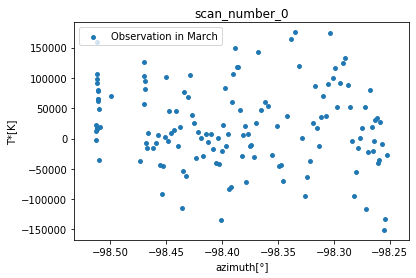

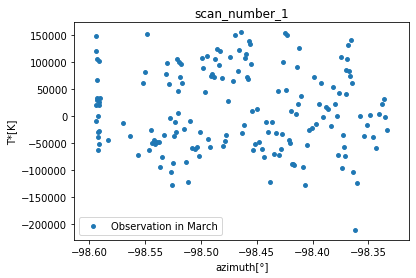

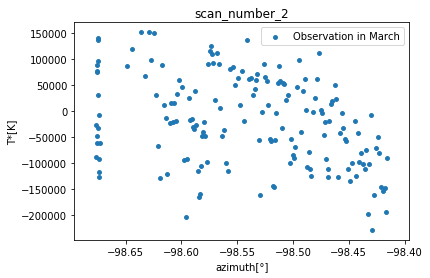

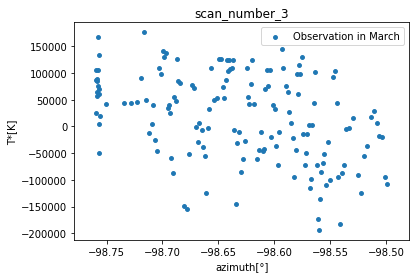

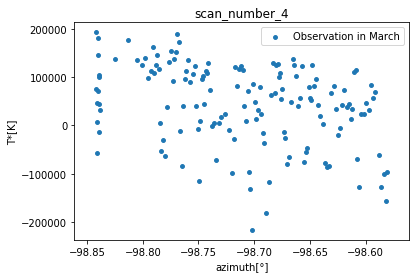

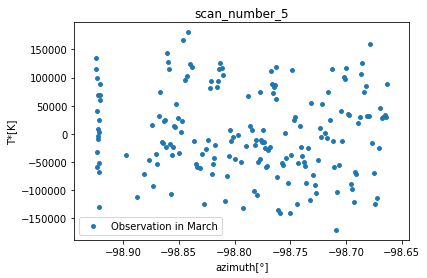

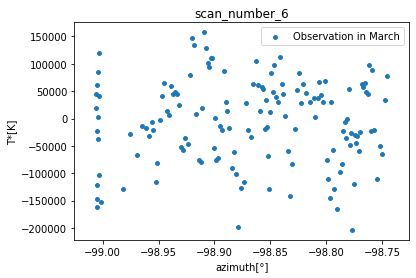

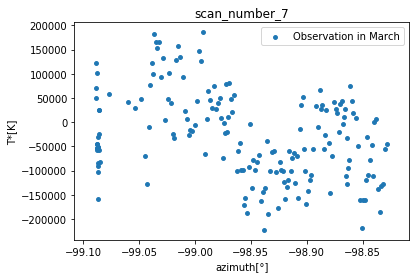

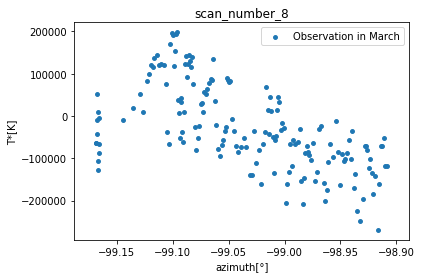

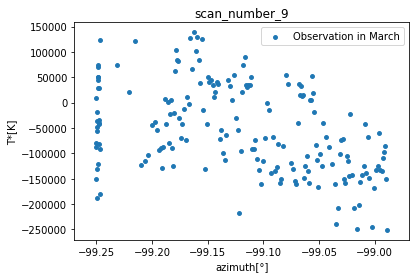

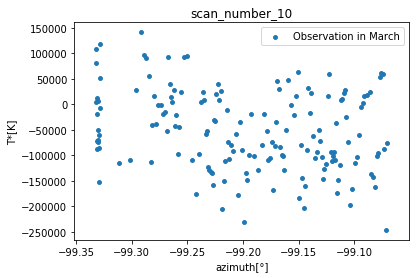

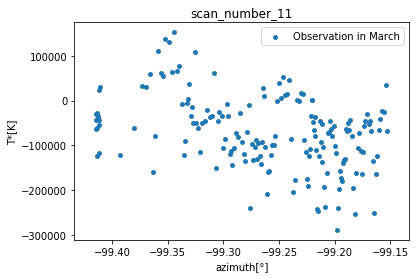

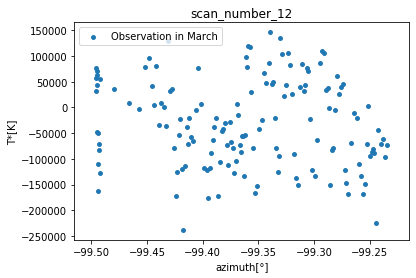

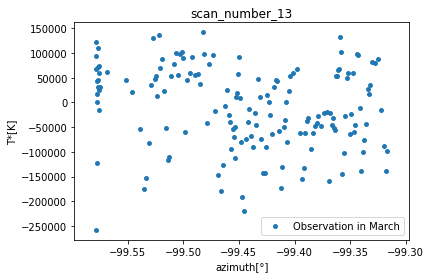

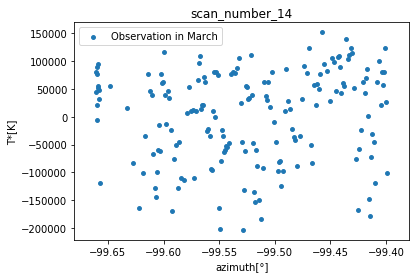

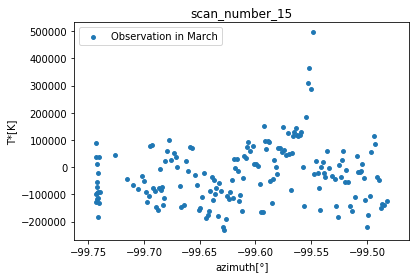

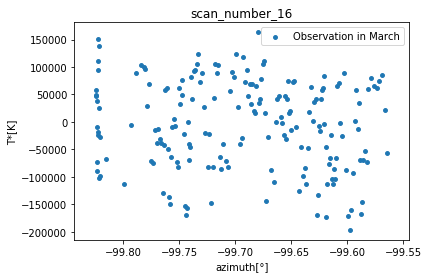

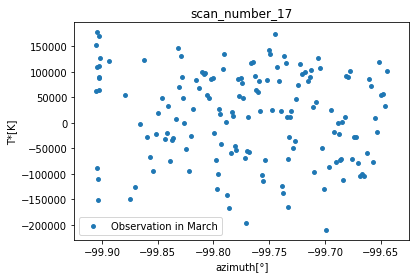

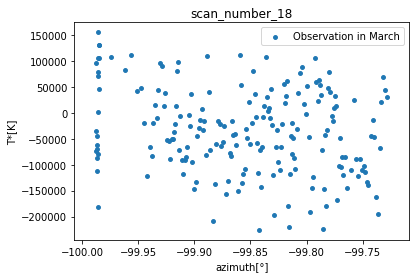

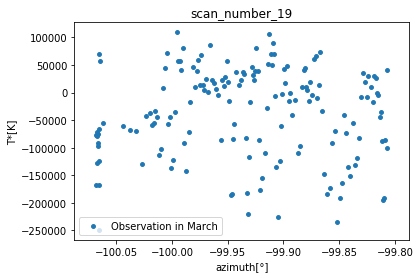

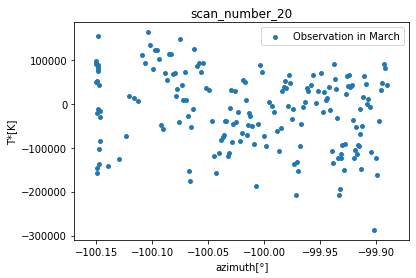

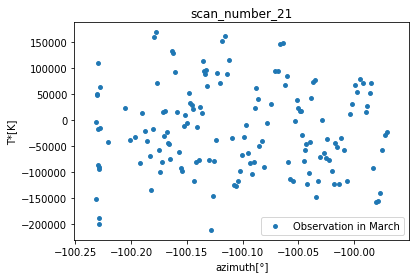

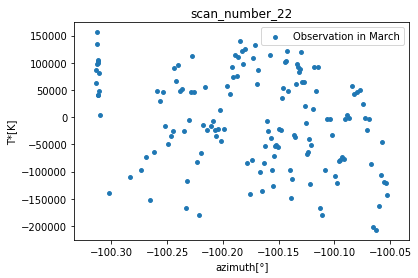

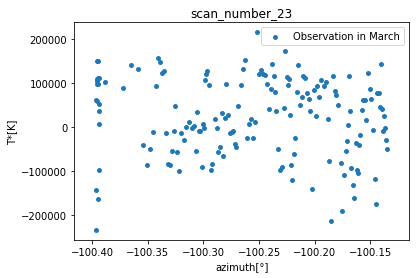

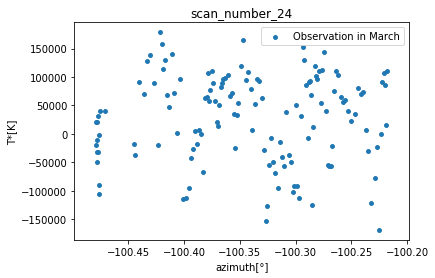

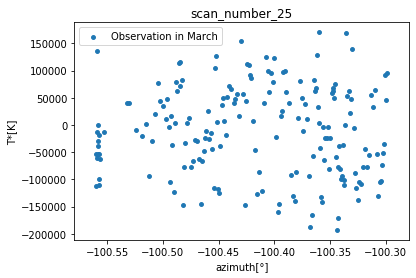

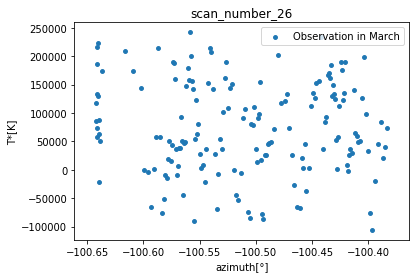

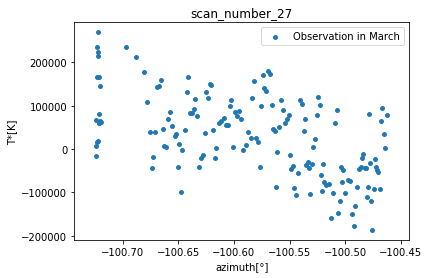

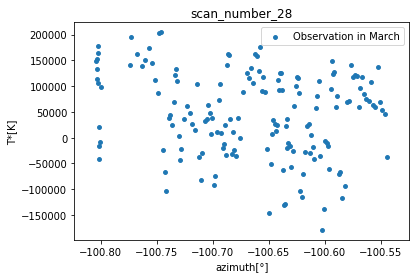

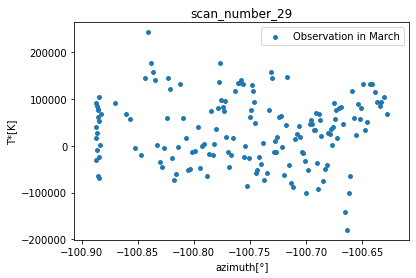

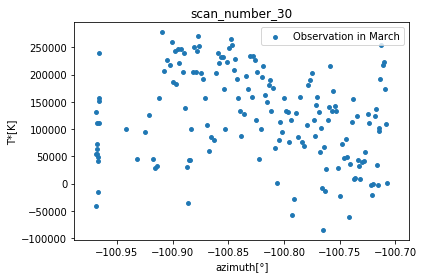

In [19]:
for i in range(len(az_list)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(az_list[i],ON_TP_list[i], s=15, label='Observation in March')
    ax.set_title('scan_number_' + f'{i}')
    ax.set_xlabel('azimuth[°]')
    ax.set_ylabel('T*[K]')
    ax.legend()
    #fig.savefig(f'/home/amigos/seigyo/analy/notebook_2020/Nishioka/per_az/az_T*_scan_nimber{i}.pdf')

/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


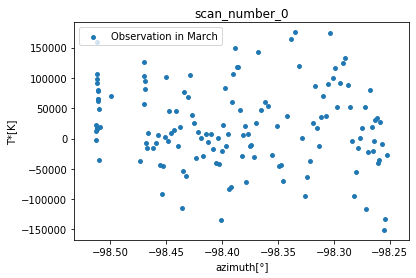

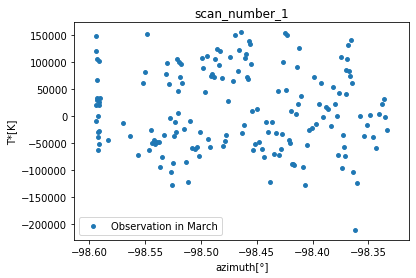

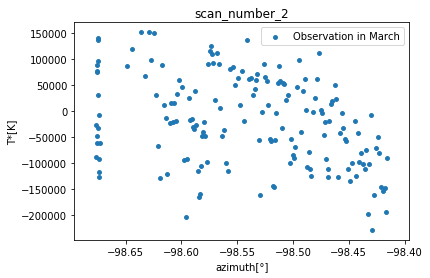

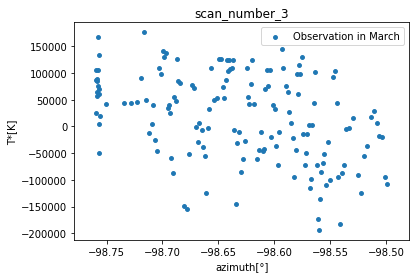

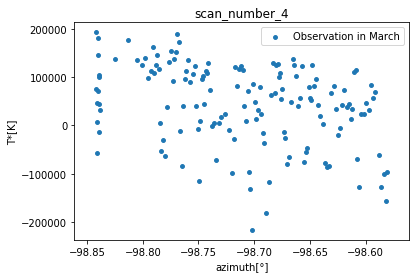

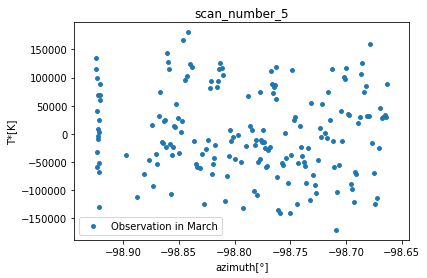

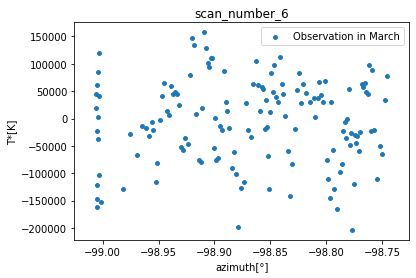

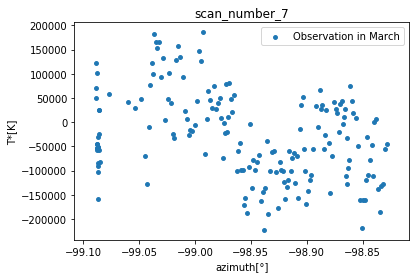

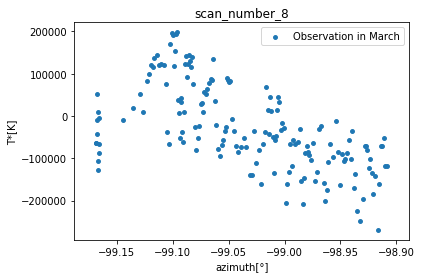

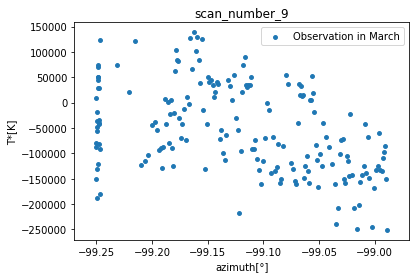

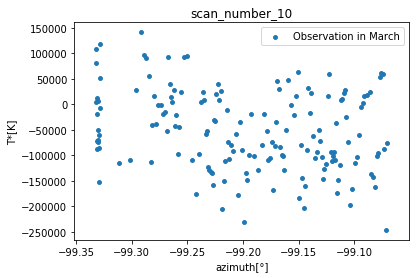

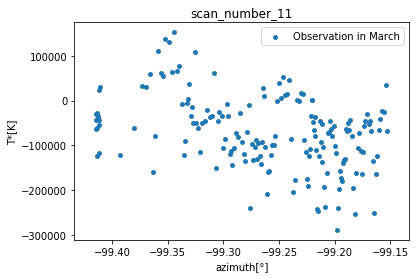

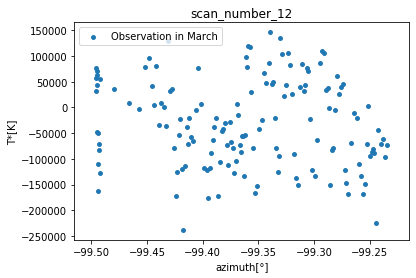

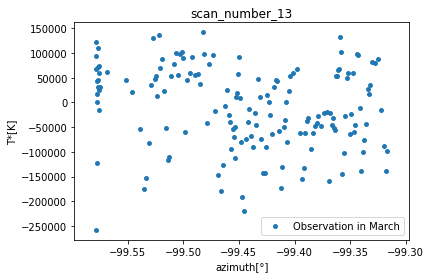

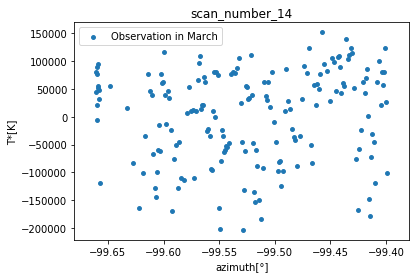

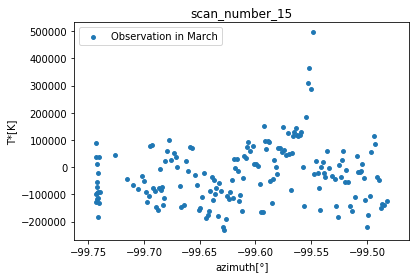

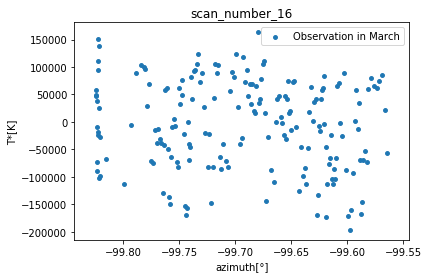

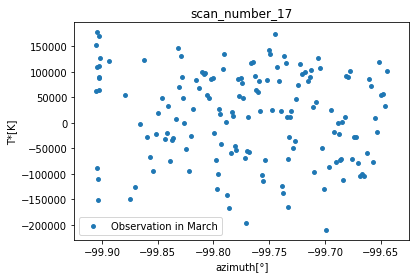

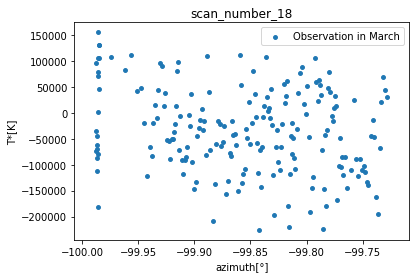

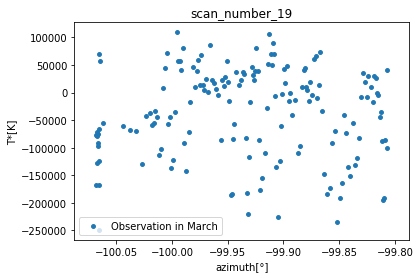

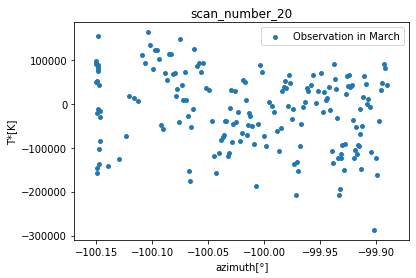

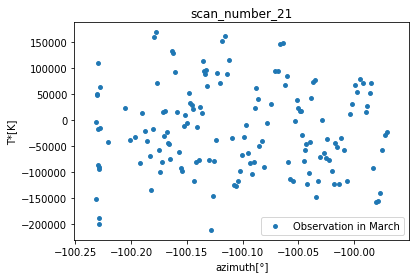

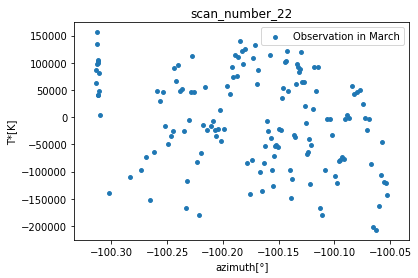

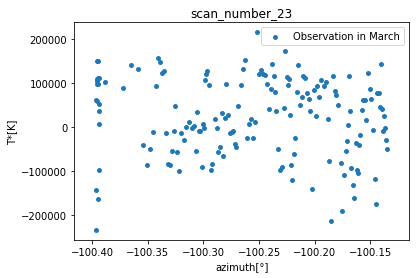

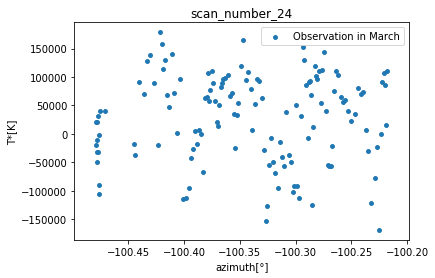

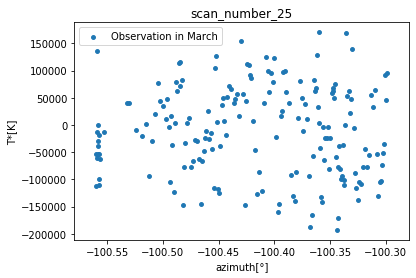

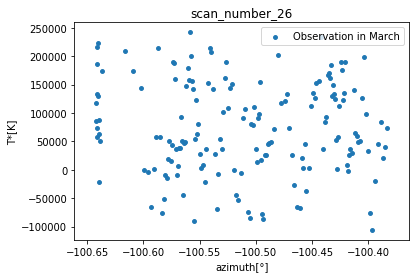

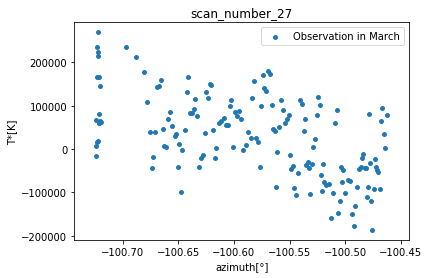

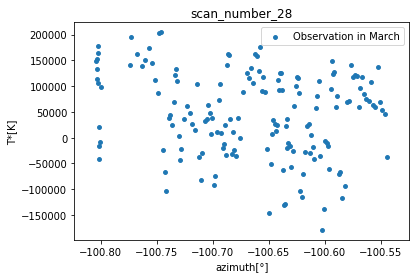

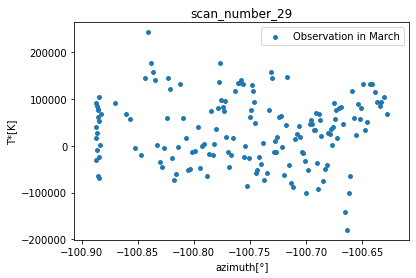

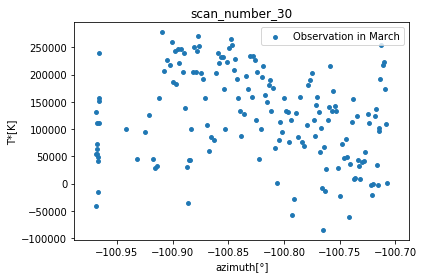

In [20]:
for i in range(len(az_list)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(az_list[i],ON_TP_list[i], s=15, label='Observation in March')
    ax.set_title('scan_number_' + f'{i}')
    ax.set_xlabel('azimuth[°]')
    ax.set_ylabel('T*[K]')
    ax.legend()
    #fig.savefig(f'/home/amigos/seigyo/analy/notebook_2020/Nishioka/per_az/az_T*_scan_nimber{i}.png')